#### Genetic Programming Example: Classification using Symbolic Regression
CE310 Evolutionary Computation and Genetic Programming<br>
Reinhold Scherer, Spring 2021, Unit 6

You get medical data (see file 'medical-test-data.npy' on Moodle). The file contains a data matrix. Column 1 and column 2 contain data of two biomarkers m1 and m2 used to characterise cancer. Column 3 contains data about the corresponding class label of test outcome (-1 negative diagnosis, +1 positive diagnosis). Each row contains data from independent tests of different persons. Your task is to find a function H(m1, m2) that classifies or predicts the outcome of the test(positive or negative).


(50, 3)
[[ 3.62778866  2.52325879 -1.        ]
 [-3.89347651  0.43125186 -1.        ]
 [-1.83613348 -0.7691131   1.        ]
 [ 0.30802502  3.17798806 -1.        ]
 [ 0.68122672  2.51844493 -1.        ]
 [ 4.51299025  0.96821573 -1.        ]
 [-2.69280275 -1.0300766  -1.        ]
 [ 0.83147359  2.58789269 -1.        ]
 [-3.60456161  2.29211762 -1.        ]
 [ 0.89761622 -1.62330603 -1.        ]
 [-4.39852854 -2.69889744 -1.        ]
 [-1.07098818 -0.93152981  1.        ]
 [-1.82436743 -1.62041294  1.        ]
 [-3.83070578  0.10337419 -1.        ]
 [-0.17270767 -2.95134162 -1.        ]
 [-4.22243827  0.83943893 -1.        ]
 [ 4.85840719  0.3347278  -1.        ]
 [-3.42501704  1.46934607 -1.        ]
 [ 1.449642   -2.29953945 -1.        ]
 [-3.2948955   0.6894296  -1.        ]
 [ 2.6479102  -0.18227039 -1.        ]
 [ 1.80828523 -0.10350919 -1.        ]
 [-1.91901522 -0.166688   -1.        ]
 [-0.6467286  -2.87562265 -1.        ]
 [ 3.2386973  -1.79080144 -1.        ]
 [-0.19887963 -0.

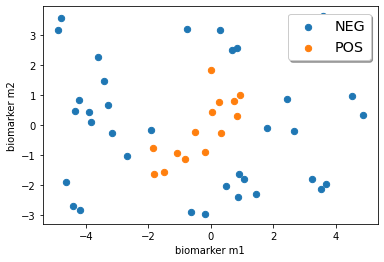

In [6]:
# 1. Load and plot the data
import matplotlib.pyplot as plt
import numpy

# load data from file
# The data contains a matrix. Each row represents one data point (observation) 
# consisitng of the triplet (biomarker m1, biomarker m2, class label)
data = numpy.load('medical-test-data.npy')
print(data.shape)
print(data)

# PCreate a 2-D scatter plot of the data
fig = plt.figure()
ax = plt.axes()
plt.scatter(data[data[:,2]==-1,0], data[data[:,2]==-1,1], s=40, label='NEG')
plt.scatter(data[data[:,2]==1,0], data[data[:,2]==1,1], s=40, label='POS')
plt.xlabel('biomarker m1')
plt.ylabel('biomarker m2')
legend = ax.legend(shadow=True, fontsize='x-large')

how can we classify the positives and negatives???

In [12]:
# 2. Run GP using the DEAP toolbox

# basically the same code as there was from the assignment

# Import relevant Python modules
import operator
import math
import random
import numpy
import sys

# Import DEAP modules
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

# ====================================================================
# GP PARAMETERS
no_generations = 30
no_population  = 2000
no_tournaments = 5
p_xo = 0.8
p_m  = 0.02

# Define new functions
def protectedDiv(left, right):
    return left / right if right else 1

# create Primitive set & classes 
# --> remove and add primitives to see the impact on the results!!

if "pset" not in globals():
    pset = gp.PrimitiveSet("MAIN", 2)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    #pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)
    pset.addTerminal(1)
    pset.addTerminal(-1)    
    #pset.addTerminal(2)
    #pset.addTerminal(-2)    
    #pset.addTerminal(3)
    #pset.addTerminal(-3)    
    #pset.addTerminal(4)
    #pset.addTerminal(-4)    
    #pset.addTerminal(5)
    #pset.addTerminal(-5)    
    pset.addTerminal(math.pi)    
    pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
    pset.renameArguments(ARG0='m1') #bio marker 1
    pset.renameArguments(ARG1='m2') #bio marker 2

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalClassification(individual, data):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)

    # minimize - in the least squares sense - the difference between the symbolic
    # regression output and the class labels ([-1, +1]). In this way we create a
    # function that outputs negaive values for class -1 and positive values for 
    # class +1 ==> classification
    sqerror = 0.0
    for i in range(data.shape[0]):
        # sum of the squares
        sqerror = sqerror + (func(m1=data[i,0], m2=data[i,1]) - data[i,2])**2
       
    return sqerror,


toolbox.register("evaluate", evalClassification, data=data)
toolbox.register("select", tools.selTournament, tournsize=no_tournaments)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=4)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

random.seed()

pop = toolbox.population(n=no_population)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("mdn", numpy.median)
#mstats.register("avg", numpy.mean)
#mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
#mstats.register("max", numpy.max)

pop, log = algorithms.eaSimple(pop, toolbox, p_xo, p_m, no_generations, stats=mstats,
                               halloffame=hof, verbose=True)


   	      	           fitness            	             size             
   	      	------------------------------	------------------------------
gen	nevals	gen	mdn    	min    	nevals	gen	mdn	min	nevals
0  	2000  	0  	143.349	33.4844	2000  	0  	3  	2  	2000  
1  	1646  	1  	57.939 	33.4844	1646  	1  	3  	2  	1646  
2  	1607  	2  	50     	32.4295	1607  	2  	3  	1  	1607  
3  	1615  	3  	50     	24.2986	1615  	3  	4  	2  	1615  
4  	1631  	4  	50     	23.6054	1631  	4  	4  	1  	1631  
5  	1640  	5  	50     	23.6054	1640  	5  	4  	1  	1640  
6  	1635  	6  	51.332 	23.6054	1635  	6  	4  	1  	1635  
7  	1650  	7  	53.7753	12.6   	1650  	7  	5  	1  	1650  
8  	1616  	8  	47.7662	12.6   	1616  	8  	6  	1  	1616  
9  	1613  	9  	46.015 	12.6   	1613  	9  	7  	1  	1613  
10 	1566  	10 	41.8099	12.6   	1566  	10 	12 	2  	1566  
11 	1596  	11 	39.8618	12.0521	1596  	11 	23 	2  	1596  
12 	1574  	12 	36.3901	11.858 	1574  	12 	25 	2  	1574  
13 	1616  	13 	33.3094	11.7266	1616  	13 	27 	1  	1616  

fitness increases over time, size also increases

In [9]:
# Best individual 
print(hof[0])

sin(add(add(protectedDiv(-1, 3.141592653589793), add(protectedDiv(-1, 3.141592653589793), cos(sub(m2, m1)))), cos(add(m1, cos(protectedDiv(add(protectedDiv(add(sub(sub(1, sin(cos(add(m1, 1)))), mul(cos(0), sin(m1))), m1), protectedDiv(protectedDiv(protectedDiv(sin(-1), 1), -1), -1)), sub(cos(sin(protectedDiv(m2, -1))), protectedDiv(m1, mul(protectedDiv(protectedDiv(sin(-1), 1), -1), mul(1, m1))))), m2))))))


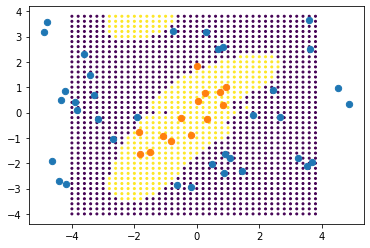

In [10]:
def plot_trained_model(f, p_low, p_high):

    m1 = m2 = numpy.arange(p_low, p_high, .2)
    M1, M2 = numpy.meshgrid(m1, m2)
    zs = numpy.zeros(M1.shape)

    for i in range(M1.shape[0]):
        for j in range(M1.shape[1]):
            zs[i,j] = f(m1=M1[i,j],m2=M2[i,j])
    
    Z = zs.reshape(M1.shape)
    Z[Z <= 0] = -1.0
    Z[Z > 0] = 1.0

    fig = plt.figure()
    ax = plt.axes()
    plt.scatter(M1, M2, s=4, c=Z)
    plt.scatter(data[data[:,2]==-1,0], data[data[:,2]==-1,1], s=40, label='NEG') 
    plt.scatter(data[data[:,2]==1,0], data[data[:,2]==1,1], s=40, label='POS')
    

f = toolbox.compile(expr=hof[0])
plot_trained_model(f, -4, 4)

blue dots: given negatives.
orange dots: given positives

purple: predicted negatives
yellow: predicted positives

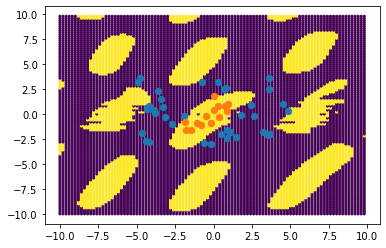

In [11]:
plot_trained_model(f, -10, 10)

we increase the range from -4,4 to -10,10.

aaaaaaaaand it's failed because it's now looping around.